In [4]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from scipy.stats import norm
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 8)

In [5]:
def computeLocalPUDensity(all_events_vertex_zs, delta_z):
    localPUdensity = []
    for vertex_zs in all_events_vertex_zs:
        localPUdensity.append((np.sum(np.abs(vertex_zs[0]-vertex_zs[1:]) < delta_z))/(2*delta_z))
    return localPUdensity

In [98]:
files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
track_t = np.array([], dtype='object')
track_z0 = np.array([], dtype='object')
track_z = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')

reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')
truth_vertex_t = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_z0 = np.concatenate((track_z0, tree['track_z0'].array(library='np')))
            track_z = np.concatenate((track_z, tree['track_z'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            
            reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))
            truth_vertex_t = np.concatenate((truth_vertex_t, tree['truthvertex_t'].array(library='np')))

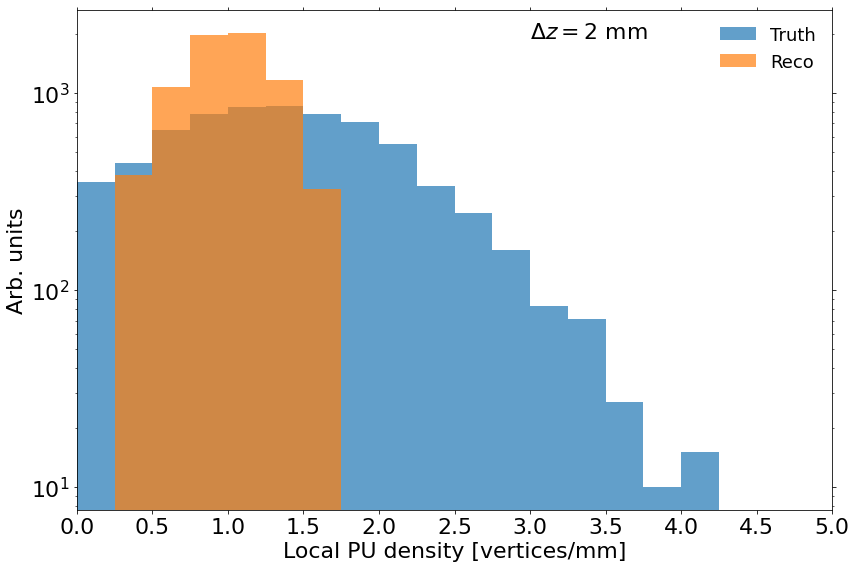

In [8]:
delta_z = 2
truth_localPU = computeLocalPUDensity(truth_vertex_z, delta_z)
reco_localPU = computeLocalPUDensity(reco_vertex_z,   delta_z)
binwidth = 1/(2*delta_z)

_, truth_bin_edges, _ = plt.hist(truth_localPU, bins=np.arange(np.min(truth_localPU), np.max(truth_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Truth')
_, reco_bin_edges, _ = plt.hist(reco_localPU,  bins=np.arange(np.min(reco_localPU), np.max(reco_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Reco')

plt.text(3, 1900, '$\\Delta z = {}$ mm'.format(delta_z), fontsize=22)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Arb. units')
plt.yscale('log')
plt.xticks(np.arange(0, 10, 0.5))
plt.xlim(0, 5)
plt.legend(frameon=False)
plt.tight_layout()

In [108]:
closest_truth_t_diff = []
closest_truth_t_diff_rms = []

sigma_cut = 1

closest_truth_t30_diff = []
closest_truth_t30_diff_rms = []
closest_truth_t30_diff_rms_sigma_cut = []

closest_truth_t90_diff = []
closest_truth_t90_diff_rms = []
closest_truth_t90_diff_rms_sigma_cut = []

closest_truth_t180_diff = []
closest_truth_t180_diff_rms = []
closest_truth_t180_diff_rms_sigma_cut = []

events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))

reco_idxs_rms_sigma_t30_cut = []
reco_idxs_rms_sigma_t90_cut = []
reco_idxs_rms_sigma_t180_cut = []


HS_t_diff = []
HS_t_diff_rms = []

no_truth_vtx_count = 0

avg_n_tracks = []
avg_n_tracks_30cut = []

for event_idxs in events_in_PU_bins:
    closest_truth_PU_bin_t_diff = np.array([])
    closest_truth_PU_bin_t30_diff = np.array([])
    closest_truth_PU_bin_t90_diff = np.array([])
    closest_truth_PU_bin_t180_diff = np.array([])
    HS_PU_bin_t_diff = []
    
    reco_n_tracks_events = []
    
    for idx in event_idxs:
        idx = idx[0]
        
        #Use reco HS - ie. largest sumpT2 vtx
        reco_track_t = track_t[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
        
        reco_n_tracks_events.append(len(reco_track_t))
        
        reco_track_t30 = track_t30[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t30 = reco_track_t30[np.logical_and(reco_track_t30 != -1e3, reco_track_t30 != -1e6)]
        reco_track_t90 = track_t90[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t90 = reco_track_t90[np.logical_and(reco_track_t90 != -1e3, reco_track_t90 != -1e6)]
        reco_track_t180 = track_t180[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t180 = reco_track_t180[np.logical_and(reco_track_t180 != -1e3, reco_track_t180 != -1e6)]
        
        closest_truth_idx = np.argmin(np.abs(truth_vertex_z[idx] - reco_vertex_z[idx][0]))
        closest_truth_t = truth_vertex_t[idx][closest_truth_idx]
        
        #Save t_reco - t_truth with different smearings - and truth being the closest vtx to reco
        closest_truth_PU_bin_t_diff = np.concatenate((closest_truth_PU_bin_t_diff, reco_track_t - closest_truth_t))
        closest_truth_PU_bin_t30_diff = np.concatenate((closest_truth_PU_bin_t30_diff, reco_track_t30 - closest_truth_t))
        closest_truth_PU_bin_t90_diff = np.concatenate((closest_truth_PU_bin_t90_diff, reco_track_t90 - closest_truth_t))
        closest_truth_PU_bin_t180_diff = np.concatenate((closest_truth_PU_bin_t180_diff, reco_track_t180 - closest_truth_t))
        
        #Truth as the truth HS
        HS_t = truth_vertex_t[idx][0]
        HS_PU_bin_t_diff = np.concatenate((HS_PU_bin_t_diff, reco_track_t - HS_t))
    
    avg_n_tracks.append(np.mean(reco_n_tracks_events))
    
    closest_truth_t_diff.append(closest_truth_PU_bin_t_diff)
    closest_truth_t_diff_rms.append(np.sqrt(np.mean(closest_truth_PU_bin_t_diff**2)))
    
    closest_truth_t30_diff.append(closest_truth_PU_bin_t30_diff)
    closest_truth_t30_diff_rms.append(np.sqrt(np.mean(closest_truth_PU_bin_t30_diff**2)))
    
    sigma_cut_idxs_30 = np.abs(closest_truth_PU_bin_t30_diff-np.mean(closest_truth_PU_bin_t30_diff)) < sigma_cut*np.std(closest_truth_PU_bin_t30_diff)
    
    closest_truth_t30_diff_rms_sigma_cut.append(\
        np.sqrt(np.mean(closest_truth_PU_bin_t30_diff[sigma_cut_idxs_30]**2)))
    
    closest_truth_t90_diff.append(closest_truth_PU_bin_t90_diff)
    closest_truth_t90_diff_rms.append(np.sqrt(np.mean(closest_truth_PU_bin_t90_diff**2)))
    closest_truth_t90_diff_rms_sigma_cut.append(\
        np.sqrt(np.mean(closest_truth_PU_bin_t90_diff[np.abs(closest_truth_PU_bin_t90_diff-np.mean(closest_truth_PU_bin_t90_diff)) < sigma_cut*np.std(closest_truth_PU_bin_t90_diff)]**2)))
    
    closest_truth_t180_diff.append(closest_truth_PU_bin_t180_diff)
    closest_truth_t180_diff_rms.append(np.sqrt(np.mean(closest_truth_PU_bin_t180_diff**2)))
    closest_truth_t180_diff_rms_sigma_cut.append(\
        np.sqrt(np.mean(closest_truth_PU_bin_t180_diff[np.abs(closest_truth_PU_bin_t180_diff-np.mean(closest_truth_PU_bin_t180_diff)) < sigma_cut*np.std(closest_truth_PU_bin_t180_diff)]**2)))
    
    #Save the RMS t sigma cut track idxs 
    bin_reco_idx30 = []
    bin_reco_idx90 = []
    bin_reco_idx180 = []
    reco_n_tracks_events_30cut = []
    for idx in event_idxs:
        idx = idx[0]
        reco_track_t30 = track_t30[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t90 = track_t90[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t180 = track_t180[idx][reco_vertex_track_idxs[idx][0]]
        
        closest_truth_idx = np.argmin(np.abs(truth_vertex_z[idx] - reco_vertex_z[idx][0]))
        closest_truth_t = truth_vertex_t[idx][closest_truth_idx]
        
        diff30 = reco_track_t30 - closest_truth_t
        diff90 = reco_track_t90 - closest_truth_t
        diff180 = reco_track_t180 - closest_truth_t
        bin_reco_idx30.append(reco_vertex_track_idxs[idx][0][np.abs(diff30 - np.mean(closest_truth_PU_bin_t30_diff)) < sigma_cut*np.std(closest_truth_PU_bin_t30_diff)])
        bin_reco_idx90.append(reco_vertex_track_idxs[idx][0][np.abs(diff90 - np.mean(closest_truth_PU_bin_t90_diff)) < sigma_cut*np.std(closest_truth_PU_bin_t90_diff)])
        bin_reco_idx180.append(reco_vertex_track_idxs[idx][0][np.abs(diff180 - np.mean(closest_truth_PU_bin_t180_diff)) < sigma_cut*np.std(closest_truth_PU_bin_t180_diff)])
        reco_n_tracks_events_30cut.append(np.sum(np.abs(diff30 - np.mean(closest_truth_PU_bin_t30_diff)) < sigma_cut*np.std(closest_truth_PU_bin_t30_diff)))
    reco_idxs_rms_sigma_t30_cut.append(bin_reco_idx30)
    reco_idxs_rms_sigma_t90_cut.append(bin_reco_idx90)
    reco_idxs_rms_sigma_t180_cut.append(bin_reco_idx180)
    
    avg_n_tracks_30cut.append(np.mean(reco_n_tracks_events_30cut))
    
    HS_t_diff.append(HS_PU_bin_t_diff)
    HS_t_diff_rms.append(np.sqrt(np.mean(HS_PU_bin_t_diff**2)))

In [10]:
closest_truth_t_diff_flat = np.concatenate(closest_truth_t_diff)
closest_truth_t30_diff_flat = np.concatenate(closest_truth_t30_diff)
closest_truth_t90_diff_flat = np.concatenate(closest_truth_t90_diff)
closest_truth_t180_diff_flat = np.concatenate(closest_truth_t180_diff)

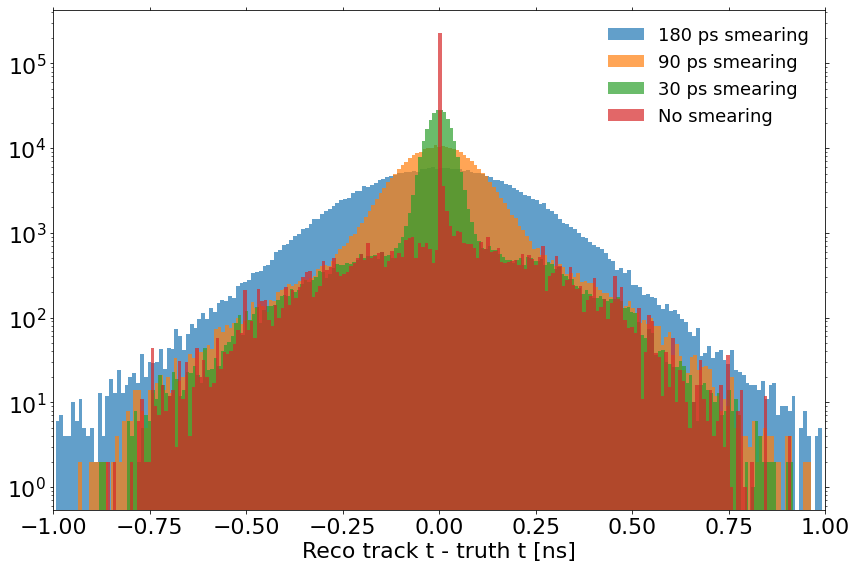

In [11]:
dt = 1
_ = plt.hist(closest_truth_t180_diff_flat[np.abs(closest_truth_t180_diff_flat) < dt], bins=200, alpha=0.7, label='180 ps smearing')
_ = plt.hist(closest_truth_t90_diff_flat[np.abs(closest_truth_t90_diff_flat) < dt],   bins=200, alpha=0.7, label='90 ps smearing')
_ = plt.hist(closest_truth_t30_diff_flat[np.abs(closest_truth_t30_diff_flat) < dt],   bins=200, alpha=0.7, label='30 ps smearing')
_ = plt.hist(closest_truth_t_diff_flat[np.abs(closest_truth_t_diff_flat) < dt],       bins=200, alpha=0.7, label='No smearing')
plt.xlim(-dt, dt)
plt.yscale('log')
plt.xlabel('Reco track t - truth t [ns]')
plt.legend(frameon=False)
plt.tight_layout()

In [12]:
#Calculate fraction of tracks x*sigma away for the different smearings
n_sigmas = [1, 2, 3, 4]
for tdiff, smear in zip((closest_truth_t30_diff_flat, closest_truth_t90_diff_flat, closest_truth_t180_diff_flat), ('30', '90', '180')):
    n_tdiff = len(tdiff)
    print(smear, 'ps smearing. sigma = {:.2f} ns'.format(np.std(tdiff)))
    for n_sigma in n_sigmas:
        n_outside = np.sum(np.abs(tdiff-np.mean(tdiff)) > n_sigma*np.std(tdiff))
        print('\t{:.3f}% of tracks are >{} sigma away'.format(n_outside/n_tdiff*100, n_sigma))

30 ps smearing. sigma = 0.11 ns
	11.470% of tracks are >1 sigma away
	6.844% of tracks are >2 sigma away
	3.384% of tracks are >3 sigma away
	1.512% of tracks are >4 sigma away
90 ps smearing. sigma = 0.14 ns
	21.279% of tracks are >1 sigma away
	5.411% of tracks are >2 sigma away
	2.035% of tracks are >3 sigma away
	0.643% of tracks are >4 sigma away
180 ps smearing. sigma = 0.21 ns
	29.370% of tracks are >1 sigma away
	4.788% of tracks are >2 sigma away
	0.727% of tracks are >3 sigma away
	0.117% of tracks are >4 sigma away


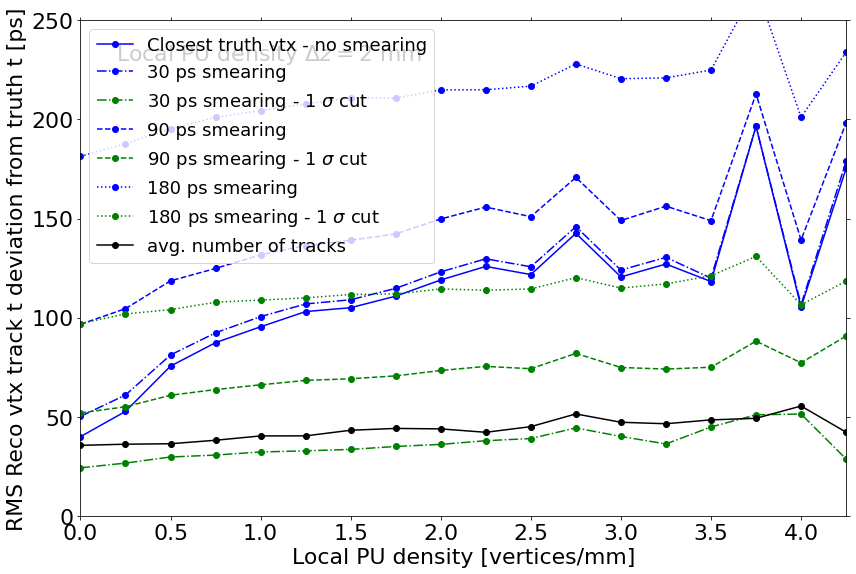

In [113]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t_diff_rms), 'bo-', label='Closest truth vtx - no smearing')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t30_diff_rms), 'bo-.', label='30 ps smearing')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t30_diff_rms_sigma_cut), 'go-.', label='30 ps smearing - {} $\\sigma$ cut'.format(sigma_cut))
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t90_diff_rms), 'bo--', label='90 ps smearing')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t90_diff_rms_sigma_cut), 'go--', label='90 ps smearing - {} $\\sigma$ cut'.format(sigma_cut))
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t180_diff_rms), 'bo:', label='180 ps smearing')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t180_diff_rms_sigma_cut), 'go:', label='180 ps smearing - {} $\\sigma$ cut'.format(sigma_cut))

plt.plot(truth_bin_edges, avg_n_tracks, 'ko-', label='avg. number of tracks')

# plt.plot(truth_bin_edges, 1e3*np.array(HS_t_diff_rms), 'go-', label='HS truth vtx')
plt.text(0.2, 230, 'Local PU density $\\Delta z = {}$ mm'.format(delta_z), fontsize=22)

plt.ylim(0, 250)
plt.xlim(0, 4.25)
plt.ylabel('RMS Reco vtx track t deviation from truth t [ps]')
plt.xlabel('Local PU density [vertices/mm]')
plt.legend(frameon=True)
plt.tight_layout()

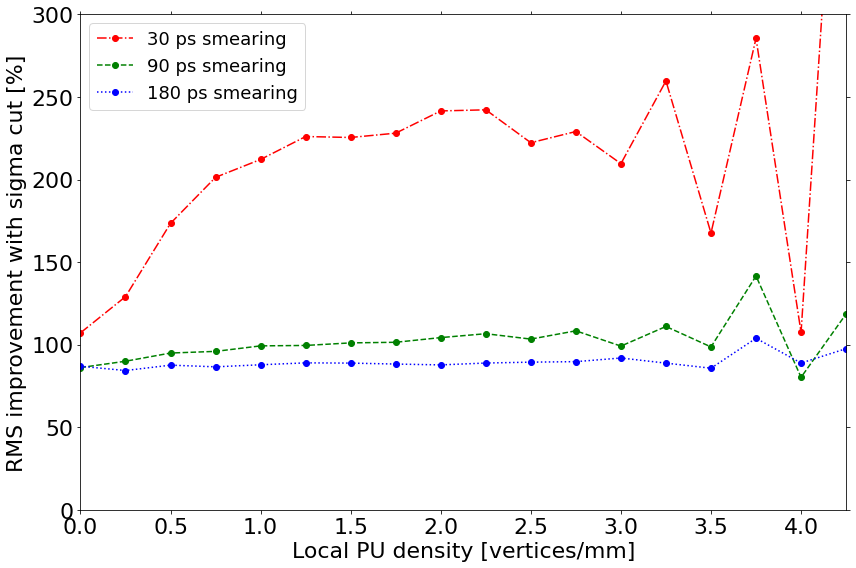

In [15]:
plt.plot(truth_bin_edges, 1e2*np.array(closest_truth_t30_diff_rms)/np.array(closest_truth_t30_diff_rms_sigma_cut) - 100, 'ro-.', label='30 ps smearing')
plt.plot(truth_bin_edges, 1e2*np.array(closest_truth_t90_diff_rms)/np.array(closest_truth_t90_diff_rms_sigma_cut) - 100, 'go--', label='90 ps smearing')
plt.plot(truth_bin_edges, 1e2*np.array(closest_truth_t180_diff_rms)/np.array(closest_truth_t180_diff_rms_sigma_cut) - 100, 'bo:', label='180 ps smearing')

plt.ylim(0, 300)
plt.xlim(0, 4.25)
plt.ylabel('RMS improvement with sigma cut [%]')
plt.xlabel('Local PU density [vertices/mm]')
plt.legend(frameon=True)
plt.tight_layout()

In [68]:
reco_idxs_rms_sigma_t30_cut[0][0]

array([   9,   58,  114,  117,  153,  230,  248,  273,  278,  326,  333,
        359,  476,  531,  544,  591,  602,  728,  740,  875, 1388],
      dtype=int32)

In [77]:
reco_idxs_rms_sigma_t30_cut[10][1], reco_vertex_track_idxs[events_in_PU_bins[10][1][0]][0]

(array([ 344,  574,  606,  845,  847,  918,  930,  946,  962,  985, 1011,
        1062, 1063, 1090, 1096, 1122, 1147, 1156, 1254, 1262, 1490, 1493,
        1510, 1727, 1732], dtype=int32),
 <STLVector [240, 344, 574, 606, 845, ..., 1510, 1598, 1727, 1732] at 0x7faca07661f0>)

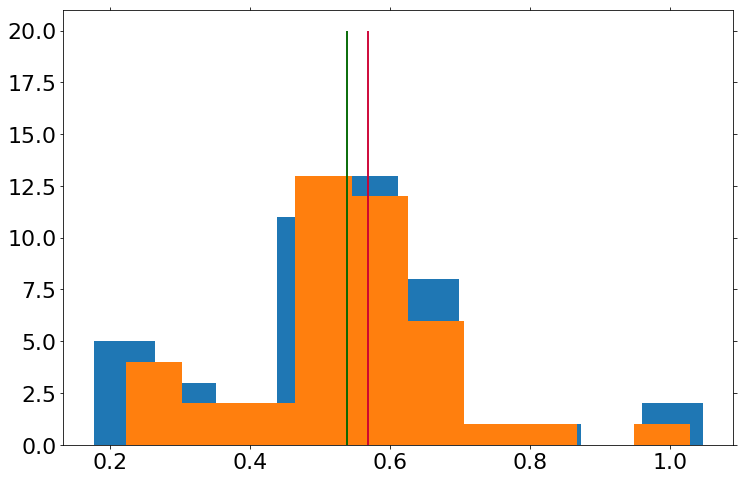

In [112]:
pu_bin = 10
pu_bin_event = -1
event = events_in_PU_bins[pu_bin][pu_bin_event][0]


_ = plt.hist(track_z0[event][reco_vertex_track_idxs[event][0]][np.abs(track_z[event][reco_vertex_track_idxs[event][0]]) < 200])
_ = plt.hist(track_z0[event][reco_idxs_rms_sigma_t30_cut[pu_bin][pu_bin_event]])

plt.vlines(truth_vertex_z[event][0], 0, 20, 'b')
plt.vlines(reco_vertex_z[event][0], 0, 20, 'r')
plt.vlines(np.mean(track_z0[event][reco_vertex_track_idxs[event][0]][np.abs(track_z0[event][reco_vertex_track_idxs[event][0]]) < 200]), 0, 20, 'k')
plt.vlines(np.mean(track_z0[event][reco_vertex_track_idxs[event][0]]), 0, 20, 'g')


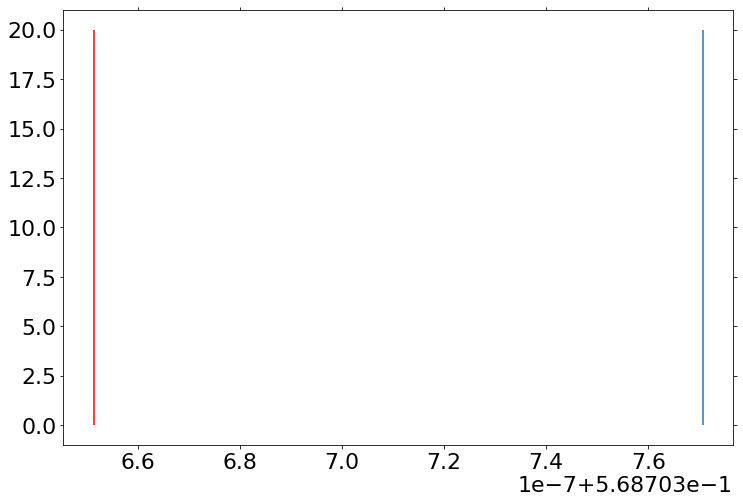

In [101]:
plt.vlines(truth_vertex_z[event][0], 0, 20)
plt.vlines(reco_vertex_z[event][0], 0, 20, 'r')
# plt.vlines(np.mean(track_z[event][reco_vertex_track_idxs[event][0]][np.abs(track_z[event][reco_vertex_track_idxs[event][0]]) < 200]), 0, 20, 'k')


In [43]:
events_in_PU_bins[0][0]

array([14])

In [ ]:
# delta_z_sigma_cut30 = []

# ## z resolution as a function of PU with and without sigma cut!
# for event_idxs in events_in_PU_bins:
#     for idx in event_idxs:
        

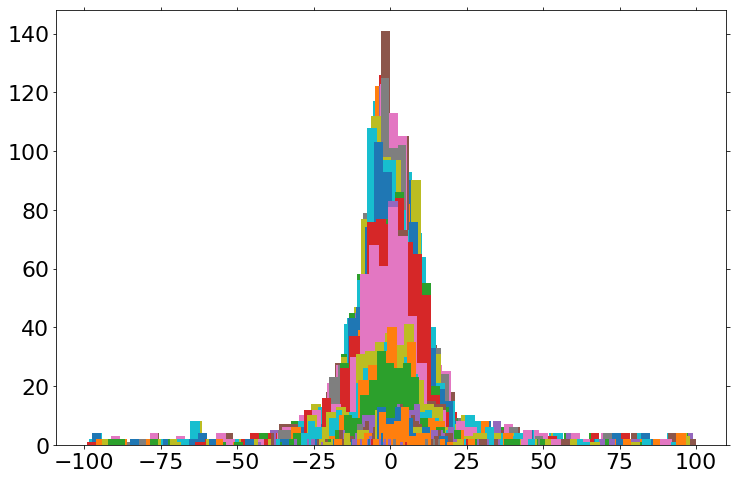

In [254]:
delta_z_max = 0.1

z_resolution5 = []
z_resolution10 = []
z_resolution15 = []

z_resolution5_std = []
z_resolution10_std = []
z_resolution15_std = []

dz_plot_max = 1e3*delta_z_max


for bin in truth_bin_edges:
    event_idxs = np.isclose(truth_localPU, bin)
    
    delta_zs_5 = np.array([])
    delta_zs_10 = np.array([])
    delta_zs_15 = np.array([])
    for tr_zs, re_zs, re_sum_pt2 in zip(truth_vertex_z[event_idxs], reco_vertex_z[event_idxs], reco_vertex_sumPt2[event_idxs]):
        
        idxs5  = re_sum_pt2 > 5**2
        idxs10 = re_sum_pt2 > 10**2
        idxs15 = re_sum_pt2 > 15**2
            
        all_delta_z5 =  flatten_array(re_zs[idxs5]-tr_zs[0])
        all_delta_z10 = flatten_array(re_zs[idxs10]-tr_zs[0])
        all_delta_z15 = flatten_array(re_zs[idxs15]-tr_zs[0])
        
        diff_idx5  = np.abs(all_delta_z5)  < delta_z_max
        diff_idx10 = np.abs(all_delta_z10) < delta_z_max
        diff_idx15 = np.abs(all_delta_z15) < delta_z_max
        
        delta_zs_5  = np.concatenate((delta_zs_5,  all_delta_z5[diff_idx5]))
        delta_zs_10 = np.concatenate((delta_zs_10, all_delta_z10[diff_idx10]))
        delta_zs_15 = np.concatenate((delta_zs_15, all_delta_z15[diff_idx15]))
    
    
    plot_idx5 =  1e3*np.abs(delta_zs_5)  < dz_plot_max
    plot_idx10 = 1e3*np.abs(delta_zs_10) < dz_plot_max
    plot_idx15 = 1e3*np.abs(delta_zs_15) < dz_plot_max

    bin_heights5, bin_borders5, _   = plt.hist(1e3*delta_zs_5 [plot_idx5],  bins = 60, label='sumPt2 > (5 GeV)$^2$')
    bin_heights10, bin_borders10, _ = plt.hist(1e3*delta_zs_10[plot_idx10], bins = 60, label='sumPt2 > (10 GeV)$^2$')
    bin_heights15, bin_borders15, _ = plt.hist(1e3*delta_zs_15[plot_idx15], bins = 60, label='sumPt2 > (15 GeV)$^2$')

    bin_centers5 = bin_borders5[:-1] + np.diff(bin_borders5) / 2
    popt5, pcov5 = curve_fit(gaussian, bin_centers5, bin_heights5,     p0=[50., 0., 7, 0])
    # popt5, pcov5 = curve_fit(gaussian, bin_centers5, bin_heights5,     p0=[500., 0., 20, 0], sigma=np.sqrt(bin_heights5), absolute_sigma=True)
    
    bin_centers10 = bin_borders10[:-1] + np.diff(bin_borders10) / 2
    popt10, pcov10 = curve_fit(gaussian, bin_centers10, bin_heights10, p0=[50., 0., 7, 0])
    # popt10, pcov10 = curve_fit(gaussian, bin_centers10, bin_heights10, p0=[500., 0., 10, 0], sigma=np.sqrt(bin_heights10), absolute_sigma=True)

    bin_centers15 = bin_borders15[:-1] + np.diff(bin_borders15) / 2
    popt15, pcov15 = curve_fit(gaussian, bin_centers15, bin_heights15, p0=[50., 0., 7, 0])
    # popt15, pcov15 = curve_fit(gaussian, bin_centers15, bin_heights15, p0=[500., 0., 10, 0], sigma=np.sqrt(bin_heights15), absolute_sigma=True)
    


    # _, std5 = norm.fit(delta_zs_5)
    # _, std10 = norm.fit(delta_zs_10)
    # _, std15 = norm.fit(delta_zs_15)
    
    z_resolution5.append (popt5[2])
    z_resolution10.append(popt10[2])
    z_resolution15.append(popt15[2])
    
    z_resolution5_std.append (pcov5[2,2]**0.5)
    z_resolution10_std.append(pcov10[2,2]**0.5)
    z_resolution15_std.append(pcov15[2,2]**0.5)

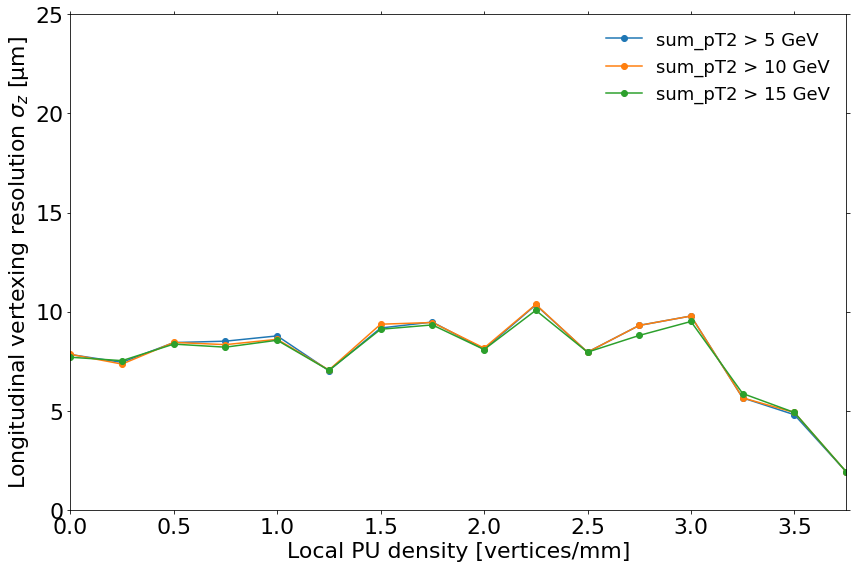

In [256]:
# plt.errorbar(truth_bin_edges, np.abs(z_resolution5) , z_resolution5_std, fmt='o-', label='sum_pT2 > 5 GeV')
# plt.errorbar(truth_bin_edges, np.abs(z_resolution10), z_resolution10_std, fmt='o-', label='sum_pT2 > 10 GeV')
# plt.errorbar(truth_bin_edges, np.abs(z_resolution15), z_resolution15_std, fmt='o-', label='sum_pT2 > 15 GeV')

plt.errorbar(truth_bin_edges, np.abs(z_resolution5) , fmt='o-', label='sum_pT2 > 5 GeV')
plt.errorbar(truth_bin_edges, np.abs(z_resolution10), fmt='o-', label='sum_pT2 > 10 GeV')
plt.errorbar(truth_bin_edges, np.abs(z_resolution15), fmt='o-', label='sum_pT2 > 15 GeV')

plt.ylabel('Longitudinal vertexing resolution $\\sigma_z$ [µm]')
plt.xlabel('Local PU density [vertices/mm]')

plt.xlim(0, 3.75)
plt.ylim(0, 25)

plt.legend(frameon=False)
plt.tight_layout()

In [2]:
def t_stats_tracks_in_vtxs(vertex_tracks_idx, track_t, v_zs):
    all_ts = []
    avg_ts = []
    rms_ts = []
    stat_zs = []
    
    for i, (event, event_zs) in enumerate(zip(vertex_tracks_idx, v_zs)):
        event_all_t = []
        event_avg_t = []
        event_rms_t = []
        event_stat_zs = []
        
        for vertex_tracks, z in zip(event, event_zs):
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks])
                ts = ts[np.logical_and(ts != -1e3, ts != -1e6)]
                event_all_t.append(ts)
                avg_t = np.mean(ts)
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
                event_stat_zs.append(z)
        all_ts.append(np.array(event_all_t))
        avg_ts.append(np.array(event_avg_t))
        rms_ts.append(np.array(event_rms_t))
        stat_zs.append(np.array(event_stat_zs))
    return np.array(all_ts, dtype='object'), np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object'), np.array(stat_zs, dtype='object')

def t_stats_tracks_in_jets(vertex_tracks_idx, track_t):
    avg_ts = []
    rms_ts = []
    
    for i, event in enumerate(vertex_tracks_idx):
        event_avg_t = []
        event_rms_t = []
        for vertex_tracks in event:
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks])
                ts = ts[np.logical_and(ts != -1e3, ts != -1e6)]
                avg_t = np.mean(ts)
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
        avg_ts.append(event_avg_t)
        rms_ts.append(event_rms_t)
    return np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object')
    
def t_stats_tracks_in_vtxs_pTcut(track_t, vertex_tracks_idx, vertex_zs, vertex_sumPt2, sumPt2_min):
    all_ts = []
    avg_ts = []
    rms_ts = []
    stat_zs = []
    
    for i, (event_vertex_track_idx, event_vertex_zs, event_vertex_sumPt2) in enumerate(zip(vertex_tracks_idx, vertex_zs, vertex_sumPt2)):
        event_all_ts =  []
        event_avg_t =   []
        event_rms_t =   []
        event_stat_zs = []
        
        hard_enough_vertex_idx = event_vertex_sumPt2 > sumPt2_min
        
        for vertex_tracks, z in zip(event_vertex_track_idx[hard_enough_vertex_idx], event_vertex_zs[hard_enough_vertex_idx]):
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks], dtype='object')
                ts = ts[np.logical_and(ts != -1e3, ts != -1e6)]
                event_all_ts.append(ts)
                
                ##Ugly hack
                event_all_ts.append(np.array([])) 
                
                avg_t = np.mean(ts)
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
                event_stat_zs.append(z)
        avg_ts.append (np.array(event_avg_t))
        rms_ts.append (np.array(event_rms_t))
        stat_zs.append(np.array(event_stat_zs))
        all_ts.append (np.array(event_all_ts, dtype='object'))
    return np.array(all_ts, dtype='object'), np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object'), np.array(stat_zs, dtype='object')



In [8]:
rev_all_ts, rev_avg_ts, rev_rms_ts, rev_stat_z = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t, reco_vertex_z)
rev_all_ts30, rev_avg_ts30, rev_rms_ts30, rev_stat_z30 = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t30, reco_vertex_z)
rev_all_ts90, rev_avg_ts90, rev_rms_ts90, rev_stat_z90 = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t90, reco_vertex_z)
rev_all_ts180, rev_avg_ts180, rev_rms_ts180, rev_stat_z180 = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t180, reco_vertex_z)

trv_all_ts, trv_avg_ts, trv_rms_ts, trv_stat_z = t_stats_tracks_in_vtxs(truth_vertex_track_idxs, track_t, truth_vertex_z)


trv_all_ts_flat = flatten_array(trv_all_ts)
rev_all_ts_flat = flatten_array(rev_all_ts)
rev_all_ts30_flat = flatten_array(rev_all_ts30)
rev_all_ts90_flat = flatten_array(rev_all_ts90)
rev_all_ts180_flat = flatten_array(rev_all_ts180)

trv_all_ts_flat2 = flatten_array(trv_all_ts_flat)
rev_all_ts_flat2 = flatten_array(rev_all_ts_flat)
rev_all_ts30_flat2 = flatten_array(rev_all_ts30_flat)
rev_all_ts90_flat2 = flatten_array(rev_all_ts90_flat)
rev_all_ts180_flat2 = flatten_array(rev_all_ts180_flat)

rev_avg_ts_flat = flatten_array(rev_avg_ts)
trv_avg_ts_flat = flatten_array(trv_avg_ts)

rev_avg_ts30_flat = flatten_array(rev_avg_ts30)
rev_avg_ts90_flat = flatten_array(rev_avg_ts90)
rev_avg_ts180_flat = flatten_array(rev_avg_ts180)

rev_rms_ts_flat = flatten_array(rev_rms_ts)
trv_rms_ts_flat = flatten_array(trv_rms_ts)

rev_stat_z_flat = flatten_array(rev_stat_z)
trv_stat_z_flat = flatten_array(trv_stat_z)

<ipython-input-5-41c7c0f5ebfe>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_ts.append(np.array(event_all_t))
/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


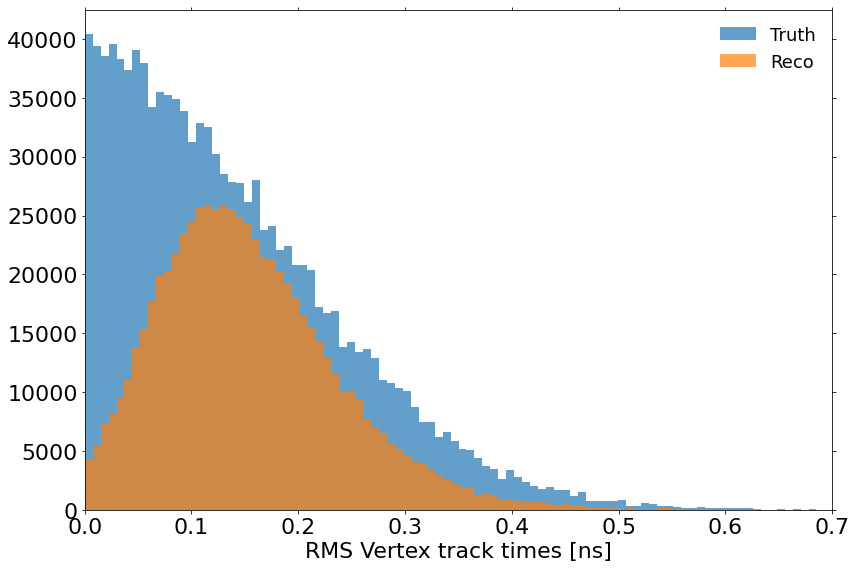

In [10]:
_ = plt.hist(trv_rms_ts_flat, bins=100, label='Truth', alpha=0.7)
_ = plt.hist(rev_rms_ts_flat, bins=100, label='Reco', alpha=0.7)
# _ = plt.hist(flatten_array(rev_rms_ts90), bins=100, label='Reco 90 ps smear', alpha=0.7)

plt.xlim(0, 0.7)
plt.xlabel('RMS Vertex track times [ns]')
plt.legend(frameon=False)
plt.tight_layout()

In [63]:
avg_t_PUbins_mean = []
avg_t_PUbins_rms = []
avg_t_PUbins_std = []
for bin in truth_bin_edges:
    event_idxs = np.isclose(truth_localPU, bin)
    avg_ts = np.array([])
    if(np.sum(event_idxs) > 0):
        avg_ts = np.concatenate(rev_avg_ts[event_idxs])
    avg_t_PUbins_mean.append(np.nanmean(avg_ts))
    avg_t_PUbins_rms.append(np.sqrt(np.nanmean(avg_ts**2)))
    avg_t_PUbins_std.append(np.nanstd(avg_ts)/np.sqrt(len(avg_ts)))

avg_t_PUbins_meanv2 = []
avg_t_PUbins_rmsv2 = []
avg_t_PUbins_stdv2 = []
for bin in truth_bin_edges:
    event_idxs = np.argwhere(np.isclose(truth_localPU, bin))
    events_avg_ts = []
    for idx in event_idxs:
        events_avg_ts.append(rev_avg_ts[idx][0][0])
    events_avg_ts = np.array(events_avg_ts)
    avg_t_PUbins_meanv2.append(np.nanmean(events_avg_ts))
    avg_t_PUbins_rmsv2.append(np.sqrt(np.nanmean(events_avg_ts**2)))
    avg_t_PUbins_stdv2.append(np.nanstd(events_avg_ts)/np.sqrt(len(events_avg_ts)))

In [64]:
#mean of rms's instead

avg_t_PUbins_meanv3 = []
avg_t_PUbins_stdv3 = []

avg_t_PUbins_rmsv3 = []
avg_t_PUbins_rmsv3_std = []
avg_t_PUbins_rms30v3 = []
avg_t_PUbins_rms30v3_std = []
avg_t_PUbins_rms90v3 = []
avg_t_PUbins_rms90v3_std = []
avg_t_PUbins_rms180v3 = []
avg_t_PUbins_rms180v3_std = []

for bin in truth_bin_edges:
    event_idxs = np.isclose(truth_localPU, bin)
    avg_ts = np.array([])
    rms_ts = np.array([])
    
    rms_ts30 = np.array([])
    rms_ts90 = np.array([])
    rms_ts180 = np.array([])
    if(np.sum(event_idxs) > 0):
        avg_ts = np.concatenate(rev_avg_ts[event_idxs])
        
        rms_ts = np.concatenate(rev_rms_ts[event_idxs])
        rms_ts30 = np.concatenate(rev_rms_ts30[event_idxs])
        rms_ts90 = np.concatenate(rev_rms_ts90[event_idxs])
        rms_ts180 = np.concatenate(rev_rms_ts180[event_idxs])
    
    avg_t_PUbins_meanv3.append(np.nanmean(avg_ts))
    avg_t_PUbins_stdv3.append(np.nanstd(avg_ts)/np.sqrt(len(avg_ts)))
    
    avg_t_PUbins_rmsv3.append(np.nanmean(rms_ts))
    avg_t_PUbins_rmsv3_std.append(np.nanstd(rms_ts)/np.sqrt(len(rms_ts)))
    
    avg_t_PUbins_rms30v3.append(np.nanmean(rms_ts30))
    avg_t_PUbins_rms30v3_std.append(np.nanstd(rms_ts30)/np.sqrt(len(rms_ts30)))
    
    avg_t_PUbins_rms90v3.append(np.nanmean(rms_ts90))
    avg_t_PUbins_rms90v3_std.append(np.nanstd(rms_ts90)/np.sqrt(len(rms_ts90)))
    
    avg_t_PUbins_rms180v3.append(np.nanmean(rms_ts180))
    avg_t_PUbins_rms180v3_std.append(np.nanstd(rms_ts180)/np.sqrt(len(rms_ts90)))

In [65]:
avg_t_PUbins_meanv4 = []
avg_t_PUbins_stdv4 = []

avg_t_PUbins_rmsv4 = []
avg_t_PUbins_rmsv4_std = []
avg_t_PUbins_rms30v4 = []
avg_t_PUbins_rms30v4_std = []
avg_t_PUbins_rms90v4 = []
avg_t_PUbins_rms90v4_std = []
avg_t_PUbins_rms180v4 = []
avg_t_PUbins_rms180v4_std = []
for bin in truth_bin_edges:
    event_idxs = np.argwhere(np.isclose(truth_localPU, bin))
    events_avg_ts = []
    events_rms_ts = []
    events_rms_ts30 = []
    events_rms_ts90 = []
    events_rms_ts180 = []
    for idx in event_idxs:
        events_avg_ts.append(rev_avg_ts[idx][0][0])
        
        events_rms_ts.append(rev_rms_ts[idx][0][0])
        events_rms_ts30.append(rev_rms_ts30[idx][0][0])
        events_rms_ts90.append(rev_rms_ts90[idx][0][0])
        events_rms_ts180.append(rev_rms_ts180[idx][0][0])

    events_avg_ts = np.array(events_avg_ts)
    avg_t_PUbins_meanv4.append(np.nanmean(events_avg_ts))
    avg_t_PUbins_stdv4.append(np.nanstd(events_avg_ts)/np.sqrt(len(events_avg_ts)))
    avg_t_PUbins_rmsv4.append(np.nanmean(events_rms_ts))
    avg_t_PUbins_rmsv4_std.append(np.nanstd(events_rms_ts)/np.sqrt(len(events_rms_ts)))
    
    avg_t_PUbins_rms30v4.append(np.nanmean(events_rms_ts30))
    avg_t_PUbins_rms30v4_std.append(np.nanstd(events_rms_ts30)/np.sqrt(len(events_rms_ts30)))
    avg_t_PUbins_rms90v4.append(np.nanmean(events_rms_ts90))
    avg_t_PUbins_rms90v4_std.append(np.nanstd(events_rms_ts90)/np.sqrt(len(events_rms_ts90)))
    avg_t_PUbins_rms180v4.append(np.nanmean(events_rms_ts180))
    avg_t_PUbins_rms180v4_std.append(np.nanstd(events_rms_ts180)/np.sqrt(len(events_rms_ts180)))

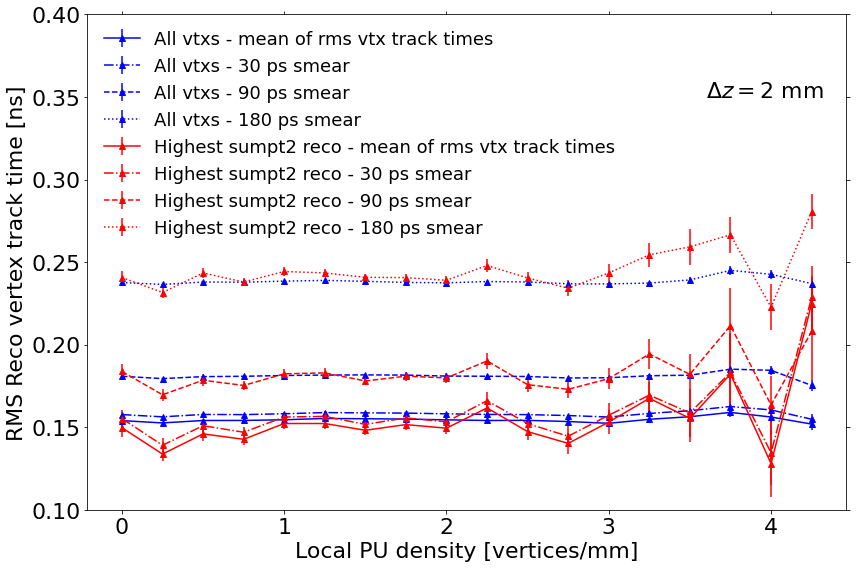

In [114]:
# plt.plot(truth_bin_edges[:-1] + 1/(4*delta_z), avg_t_PUbins_rms,   'bo--', label='All vtxs - rms of mean vtx track times')
# plt.plot(truth_bin_edges[:-1] + 1/(4*delta_z), avg_t_PUbins_rmsv2, 'ro--', label='Highest sumpt2 reco - rms of mean vtx track times')

plt.errorbar(truth_bin_edges, avg_t_PUbins_rmsv3, avg_t_PUbins_rmsv3_std, fmt='^-', color='blue', label='All vtxs - mean of rms vtx track times')

plt.errorbar(truth_bin_edges, avg_t_PUbins_rms30v3, avg_t_PUbins_rms90v3_std, fmt='^-.', color='blue', label='All vtxs - 30 ps smear')
plt.errorbar(truth_bin_edges, avg_t_PUbins_rms90v3, avg_t_PUbins_rms90v3_std, fmt='^--', color='blue', label='All vtxs - 90 ps smear')
plt.errorbar(truth_bin_edges, avg_t_PUbins_rms180v3, avg_t_PUbins_rms180v3_std, fmt='^:', color='blue', label='All vtxs - 180 ps smear')

plt.errorbar(truth_bin_edges, avg_t_PUbins_rmsv4, avg_t_PUbins_rmsv4_std, fmt='^-', color='red', label='Highest sumpt2 reco - mean of rms vtx track times')
plt.errorbar(truth_bin_edges, avg_t_PUbins_rms30v4, avg_t_PUbins_rms30v4_std, fmt='^-.', color='red', label='Highest sumpt2 reco - 30 ps smear')
plt.errorbar(truth_bin_edges, avg_t_PUbins_rms90v4, avg_t_PUbins_rms90v4_std, fmt='^--', color='red', label='Highest sumpt2 reco - 90 ps smear')
plt.errorbar(truth_bin_edges, avg_t_PUbins_rms180v4, avg_t_PUbins_rms180v4_std, fmt='^:', color='red', label='Highest sumpt2 reco - 180 ps smear')

plt.ylim(0.1, 0.40)
plt.text(3.6, 0.35, '$\\Delta z = {}$ mm'.format(delta_z), fontsize=22)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('RMS Reco vertex track time [ns]')
plt.legend(frameon=False, loc='upper left')

plt.tight_layout()